# Xente fraud detection

## Content

1. Intro
2. Setup and import
3. Exploring and cleaning the data
4. Feature engineering
5. Modeling

## 1. Intro
Xente is a payment service.
In this notebook, we explore data of transactions.

**The goal is to build a model, that predicts wheter or not a transaction is fraudulent.**

Have a look on the website or this video to learn more.

Video: https://www.loom.com/share/95af830a57f5452085fe73e2f4edd414

Website: https://www.xente.co


## 2. Set-up and Import

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

###
# Import functions from own Python-File (see visuals_script.py in Repo)
import visuals_script as vs

# Pretty display for notebooks
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

RSEED = 42
###


# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')

## 3. Exploring and cleaning the data
The data is available on zindi: https://zindi.africa/competitions/xente-fraud-detection-challenge/data

In [2]:
df = pd.read_csv('data/training.csv')
df.columns = df.columns.str.lower()
#df.head()

In [3]:
# General information
# df.info()
# df.describe()
# df.nunique()


In [4]:
# Checking the target value
# sns.countplot(x=df.fraudresult)
# The data is highly imbalanced. 96000 non-frauds and 200 frauds.

In [5]:
# Currencycode and countrycode is the same for all transactions and contains no valuable information.
df.drop('currencycode', axis=1, inplace=True)
df.drop('countrycode', axis=1, inplace=True)

In [6]:
# Transforming the transaction start time into datetime
# The date is splitted into year, month, day, hour and weekday
# While doing this, we discussed a lot about the meaning of the date and time. Is the year or the second something, that contain information valuable for future fraud detection?
# Would you in practice try to keep as many of those variables as possible at first, then eventually throw them out after building your model?

df['transactionstarttime'] = df['transactionstarttime'].str.replace('T', ' ')
df['transactionstarttime'] = df['transactionstarttime'].str.replace('Z', '')
df['transactionstarttime'] = pd.to_datetime(df['transactionstarttime'], infer_datetime_format=True) 
df['year'] = df['transactionstarttime'].dt.year
df['month'] = df['transactionstarttime'].dt.month
df['day'] = df['transactionstarttime'].dt.day
df['hour'] = df['transactionstarttime'].dt.hour
df['weekday'] = df['transactionstarttime'].dt.weekday

df.drop('transactionstarttime', axis=1, inplace=True)


#### Trying to make sense of the ID columns

**transactionid:** Unique transaction identifier on platform

**batchid:** Unique number assigned to a batch of transactions for processing

**accountid:** Unique number identifying the customer on (xente) platform

**subscriptionid:** identifying the customer subscription

**customerid:** Unique identifier attached to Account

**providerid:** Identifying the provider of the product (for example phone company for airtime)

**productid:** Product being bought (23 different products)

**channelid:** Identifies if customer used web,Android, IOS, pay later or checkout.(4 categories)

**productcategory:** ProductIds are organized into these broader product categories. (9 categories)

In [7]:
# df['accountid'].value_counts()
# df['subscriptionid'].value_counts()
# df['customerid'].value_counts()
# df['providerid'].value_counts()
# df['channelid'].value_counts()
#df['productcategory'].value_counts()


In [8]:
# Cleaning the id columns
df["transactionid"] = df["transactionid"].apply(lambda x: x.replace("TransactionId_", ""))
df["batchid"] = df["batchid"].apply(lambda x: x.replace("BatchId_", ""))
df["accountid"] = df["accountid"].apply(lambda x: x.replace("AccountId_", ""))
df["customerid"] = df["customerid"].apply(lambda x: x.replace("CustomerId_", ""))
df["providerid"] = df["providerid"].apply(lambda x: x.replace("ProviderId_", ""))
df["productid"] = df["productid"].apply(lambda x: x.replace("ProductId_", ""))
df["channelid"] = df["channelid"].apply(lambda x: x.replace("ChannelId_", ""))
df["subscriptionid"] = df["subscriptionid"].apply(lambda x: x.replace("SubscriptionId_", ""))

**How to decide, whether or not to keep an ID? Does it make sense to drop unique IDs and keep categorical IDs?**

The batch_id for example is categorical, but has nearly 95000 unique values. 

Does it make sense to keep this and create dummies?

In [9]:
# We decided to drop most of the IDs
df = df.drop(['transactionid', 'batchid', 'accountid', 'subscriptionid', 'customerid'], axis=1)


In [10]:
df.head()

,providerid,productid,productcategory,channelid,amount,value,pricingstrategy,fraudresult,year,month,day,hour,weekday
0,6,10,airtime,3,1000.0,1000,2,0,2018,11,15,2,3
1,4,6,financial_services,2,-20.0,20,2,0,2018,11,15,2,3
2,6,1,airtime,3,500.0,500,2,0,2018,11,15,2,3
3,1,21,utility_bill,3,20000.0,21800,2,0,2018,11,15,3,3
4,4,6,financial_services,2,-644.0,644,2,0,2018,11,15,3,3


## 4. Feature Engineering

In [11]:
# The value and amount column contain nearly the same information. The only difference is, that the amount column shows, whether a transaction was a debit or a credit. 
# Therefor we decided to change the amount column, so it only shows this additional information.
df["debit"] = df["amount"].apply(lambda x: 0 if x > 0 else 1)
# df[["amount", "debit"]]
df.drop('amount', axis=1, inplace=True)

In [12]:
# df[df['fraudresult'] == 1].groupby('productcategory').count()
# df[df['fraudresult'] == 1].groupby('channelid').count()
# df[df['fraudresult'] == 1].groupby('productid').count()
# df[df['fraudresult'] == 1].groupby('value').count().sort_values('value',ascending=False).head(60)

### Creating dummies

In [13]:
X = df.drop('fraudresult', axis=1)
y = df.fraudresult

In [14]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = X
cat_feats = ['providerid', 'productid', 'productcategory', 'channelid', 'pricingstrategy', 'year', 'month', 'day', 'hour', 'weekday']
features_dummies = pd.get_dummies(features, columns=cat_feats, drop_first=True)

# TODO: Our Target is already a numerical value with 0 for ok and 1 for fraud
target_enc = y 

# features_dummies.head()
# features_dummies.shape
# features_dummies.info()
# X.info()

### Shuffle and Split Data

Now all _categorical variables_ have been converted into numerical features. We will now split the data (both features and their labels) into training and test sets. 70% of the data will be used for training and 30% for testing.  

In [15]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_dummies, target_enc, test_size=0.3, random_state=RSEED, stratify= target_enc)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 66963 samples.
Testing set has 28699 samples.


### Normalizing Numerical Features
Normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below. To avoid data leakage we will normalize the data after we split it into train and test set. 

In [16]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import StandardScaler

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
numerical = ['value']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical] = scaler.fit_transform(X_train_scaled[numerical])
X_test_scaled[numerical] = scaler.transform(X_test_scaled[numerical])

# Show an example of a record with scaling applied
# X_train_scaled.head()

### Synthetic minority oversampling

To deal with the imbalance, we decided to create new fraud instances using SMOTE. These will only be used to train our model.

In [17]:
# summarize class distribution
counter = Counter(y_train)
print(counter)


Counter({0: 66828, 1: 135})


In [18]:
# transform the dataset
# do all imports at the top
oversample = SMOTE()
X_train_sample, y_train_sample = oversample.fit_resample(X_train_scaled, y_train)


In [19]:
# summarize the new class distribution
counter = Counter(y_train_sample)
print(counter)

Counter({0: 66828, 1: 66828})


## 5. Modeling

### Metric
Our main focus is to prevent fraudulent transactions (high recall). 

At the same time, we don't want the model to be too sensitive and prevent non-fraudulent transactions (high precision).

Therefor we chose the F1-score as a metric, since it optimizes the balance between recall and precision.

### Baseline Model:
As a starting point, we create a simple baseline model. When exploring the data, we saw, that higher transaction values are more likely to be fraudulent.

Let's test a model, that predicts the following:

A transaction is always fraudulent, if the value is higher than 500.000 UGX

In [20]:
# Create prediction of our baseline model
y_pred_baseline = (X_test.value >= 500000)*1

# Testing it on the test data
print("Accuracy: ", accuracy_score(y_test, y_pred_baseline))
print("Recall: ", recall_score(y_test, y_pred_baseline))
print("Precision: ", precision_score(y_test, y_pred_baseline))
print("F1-score: ", f1_score(y_test, y_pred_baseline))
print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred_baseline))

Accuracy:  0.9990243562493467
Recall:  0.8793103448275862
Precision:  0.7083333333333334
F1-score:  0.7846153846153847
Confusion matrix:
[[28620    21]
 [    7    51]]


##  Supervised Learning Models

###  Model Application

Now we'll pick three supervised learning models above that are appropriate for this problem, and test them on our data. 

In [21]:
def train_predict_evaluate(model, X_train, y_train, X_test, y_test, fbeta=1.0):
    """Train model, make prediction and evaluate

    Args:
        model (_type_): Classifier model
        X_train (_type_): Train data features
        y_train (_type_): Train data target
        X_test (_type_): Test data features
        y_test (_type_): Test data target
        fbeta (float, optional): Beta for f_beta score. Defaults to 1.0.
    """
    # train model
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # print metrics of predictions
    print(f"Model: {type(model)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"recall: {recall_score(y_test, y_pred)}")
    print(f"F_beta: {fbeta_score(y_test, y_pred, beta=fbeta)}")
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, y_pred))
    print('-----------------------------')

###  Without SMOTE


In [22]:
# excluded the SVC because it took really long to train it
from sklearn.ensemble import AdaBoostClassifier
# TODO: Train a decision tree, SVM and AdaBoostClassifier on the train data
model_dtree = DecisionTreeClassifier(random_state=RSEED)
model_svc = SVC()
model_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

for model in [model_dtree, model_adaboost]:
    train_predict_evaluate(model, X_train_scaled, y_train, X_test_scaled, y_test, fbeta=1)

Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy: 0.9994076448656748
recall: 0.8448275862068966
F_beta: 0.8521739130434783
Confusion matrix: 
[[28633     8]
 [    9    49]]
-----------------------------
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Accuracy: 0.9993379560263423
recall: 0.7758620689655172
F_beta: 0.8256880733944953
Confusion matrix: 
[[28635     6]
 [   13    45]]
-----------------------------


In [23]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 

# Initialize the classifier
clf = model_adaboost 


# Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(3, 8, 2)              
             } 

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=1) 


# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
gs = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scorer, cv=5, verbose = 2)
gs_sample = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scorer, cv=5, verbose = 2)

# TODO: Fit the grid search object to the training data and find the optimal parameters
gs.fit(X_train_scaled, y_train)
gs_sample.fit(X_train_sample, y_train_sample)

#Runtime: 26m47s

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50; total time=   7.8s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50; total time=   8.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50; total time=   7.9s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50; total time=   7.9s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50; total time=   8.2s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50; total time=   7.5s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50; total time=   7.5s
[CV] END base_estimator__max

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': array([3, 5, 7]),
                         'base_estimator__min_samples_split': array([2, 4, 6]),
                         'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 120]},
             scoring=make_scorer(fbeta_score, beta=1), verbose=2)

In [24]:
# TODO: Get the  best estimator
best_clf = gs.best_estimator_

# TODO: Make predictions using the unoptimized model
predictions = clf.predict(X_test_scaled)

# TODO: Make predictions using the optimized model
best_predictions = best_clf.predict(X_test_scaled)

# Report the before-and-afterscores
print("Without SMOTE")
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 1)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 1)))
cfm = confusion_matrix(y_test, best_predictions)
print(best_clf)

print("Baseline model:")
print("Accuracy: ", accuracy_score(y_test, y_pred_baseline))
print("Recall: ", recall_score(y_test, y_pred_baseline))
print("Precision: ", precision_score(y_test, y_pred_baseline))
print("F1-score: ", f1_score(y_test, y_pred_baseline))
print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred_baseline))

Without SMOTE
Unoptimized model
------
Accuracy score on testing data: 0.9993
Recall score on testing data: 0.7759
F-score on testing data: 0.8257

Optimized Model
------
Final accuracy score on the testing data: 0.9996
Final recall score on the testing data: 0.8621
Final F-score on the testing data: 0.8929
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1)
Baseline model:
Accuracy:  0.9990243562493467
Recall:  0.8793103448275862
Precision:  0.7083333333333334
F1-score:  0.7846153846153847
Confusion matrix:
[[28620    21]
 [    7    51]]


###  With SMOTE


In [27]:
for model in [model_dtree, model_adaboost]:
    train_predict_evaluate(model, X_train_sample, y_train_sample, X_test_scaled, y_test, fbeta=1)

Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy: 0.9989198229903481
recall: 0.8103448275862069
F_beta: 0.752
Confusion matrix: 
[[28621    20]
 [   11    47]]
-----------------------------
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Accuracy: 0.9993379560263423
recall: 0.8620689655172413
F_beta: 0.8403361344537814
Confusion matrix: 
[[28630    11]
 [    8    50]]
-----------------------------


In [28]:
# Initialize the classifier
clf_sample = model_adaboost 


# Create the parameters list you wish to tune
parameters_sample = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(3, 8, 2)              
             } 

# Make an fbeta_score scoring object
scorer_sample = make_scorer(fbeta_score,beta=1) 


# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
gs_sample = GridSearchCV(clf, parameters_sample, n_jobs=-1, scoring=scorer_sample, cv=3, verbose = 2)

# TODO: Fit the grid search object to the training data and find the optimal parameters
gs_sample.fit(X_train_sample, y_train_sample)

#Runtime: 11m47s

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50; total time=  13.7s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50; total time=  13.9s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.1, n_estimators=50; total time=  14.2s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50; total time=  13.7s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50; total time=  13.9s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=0.5, n_estimators=50; total time=  13.5s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_split=2, learning_rate=1.0, n_estimators=50; total time=  13.7s
[CV] END base_estimator__max

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': array([3, 5, 7]),
                         'base_estimator__min_samples_split': array([2, 4, 6]),
                         'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 120]},
             scoring=make_scorer(fbeta_score, beta=1), verbose=2)

In [29]:
# TODO: Get the  best estimator
best_clf_sample = gs_sample.best_estimator_

# TODO: Make predictions using the unoptimized model
predictions_sample = clf.predict(X_test_scaled)

# TODO: Make predictions using the optimized model
best_predictions_sample = best_clf_sample.predict(X_test_scaled)

# Report the before-and-afterscores
print("With SMOTE")
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_sample)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, predictions_sample)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions_sample, beta = 1)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_sample)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions_sample)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions_sample, beta = 1)))
cfm = confusion_matrix(y_test, best_predictions_sample)
print(best_clf_sample)

With SMOTE
Unoptimized model
------
Accuracy score on testing data: 0.9993
Recall score on testing data: 0.8621
F-score on testing data: 0.8403

Optimized Model
------
Final accuracy score on the testing data: 0.9994
Final recall score on the testing data: 0.8276
Final F-score on the testing data: 0.8571
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7,
                                                         min_samples_split=6))


# Questions

1. SMOTE and GridSeach
    It seems like in our case, the model performs better without SMOTE.
    What did we do wrong?     
    Does our GridSearch makes sense? 

2. How to show the feature importance for the final model (and make sense of it)? 
   We tried something like in the cell below.

3. Are there any important steps missing in our notebook? 



<BarContainer object of 106 artists>

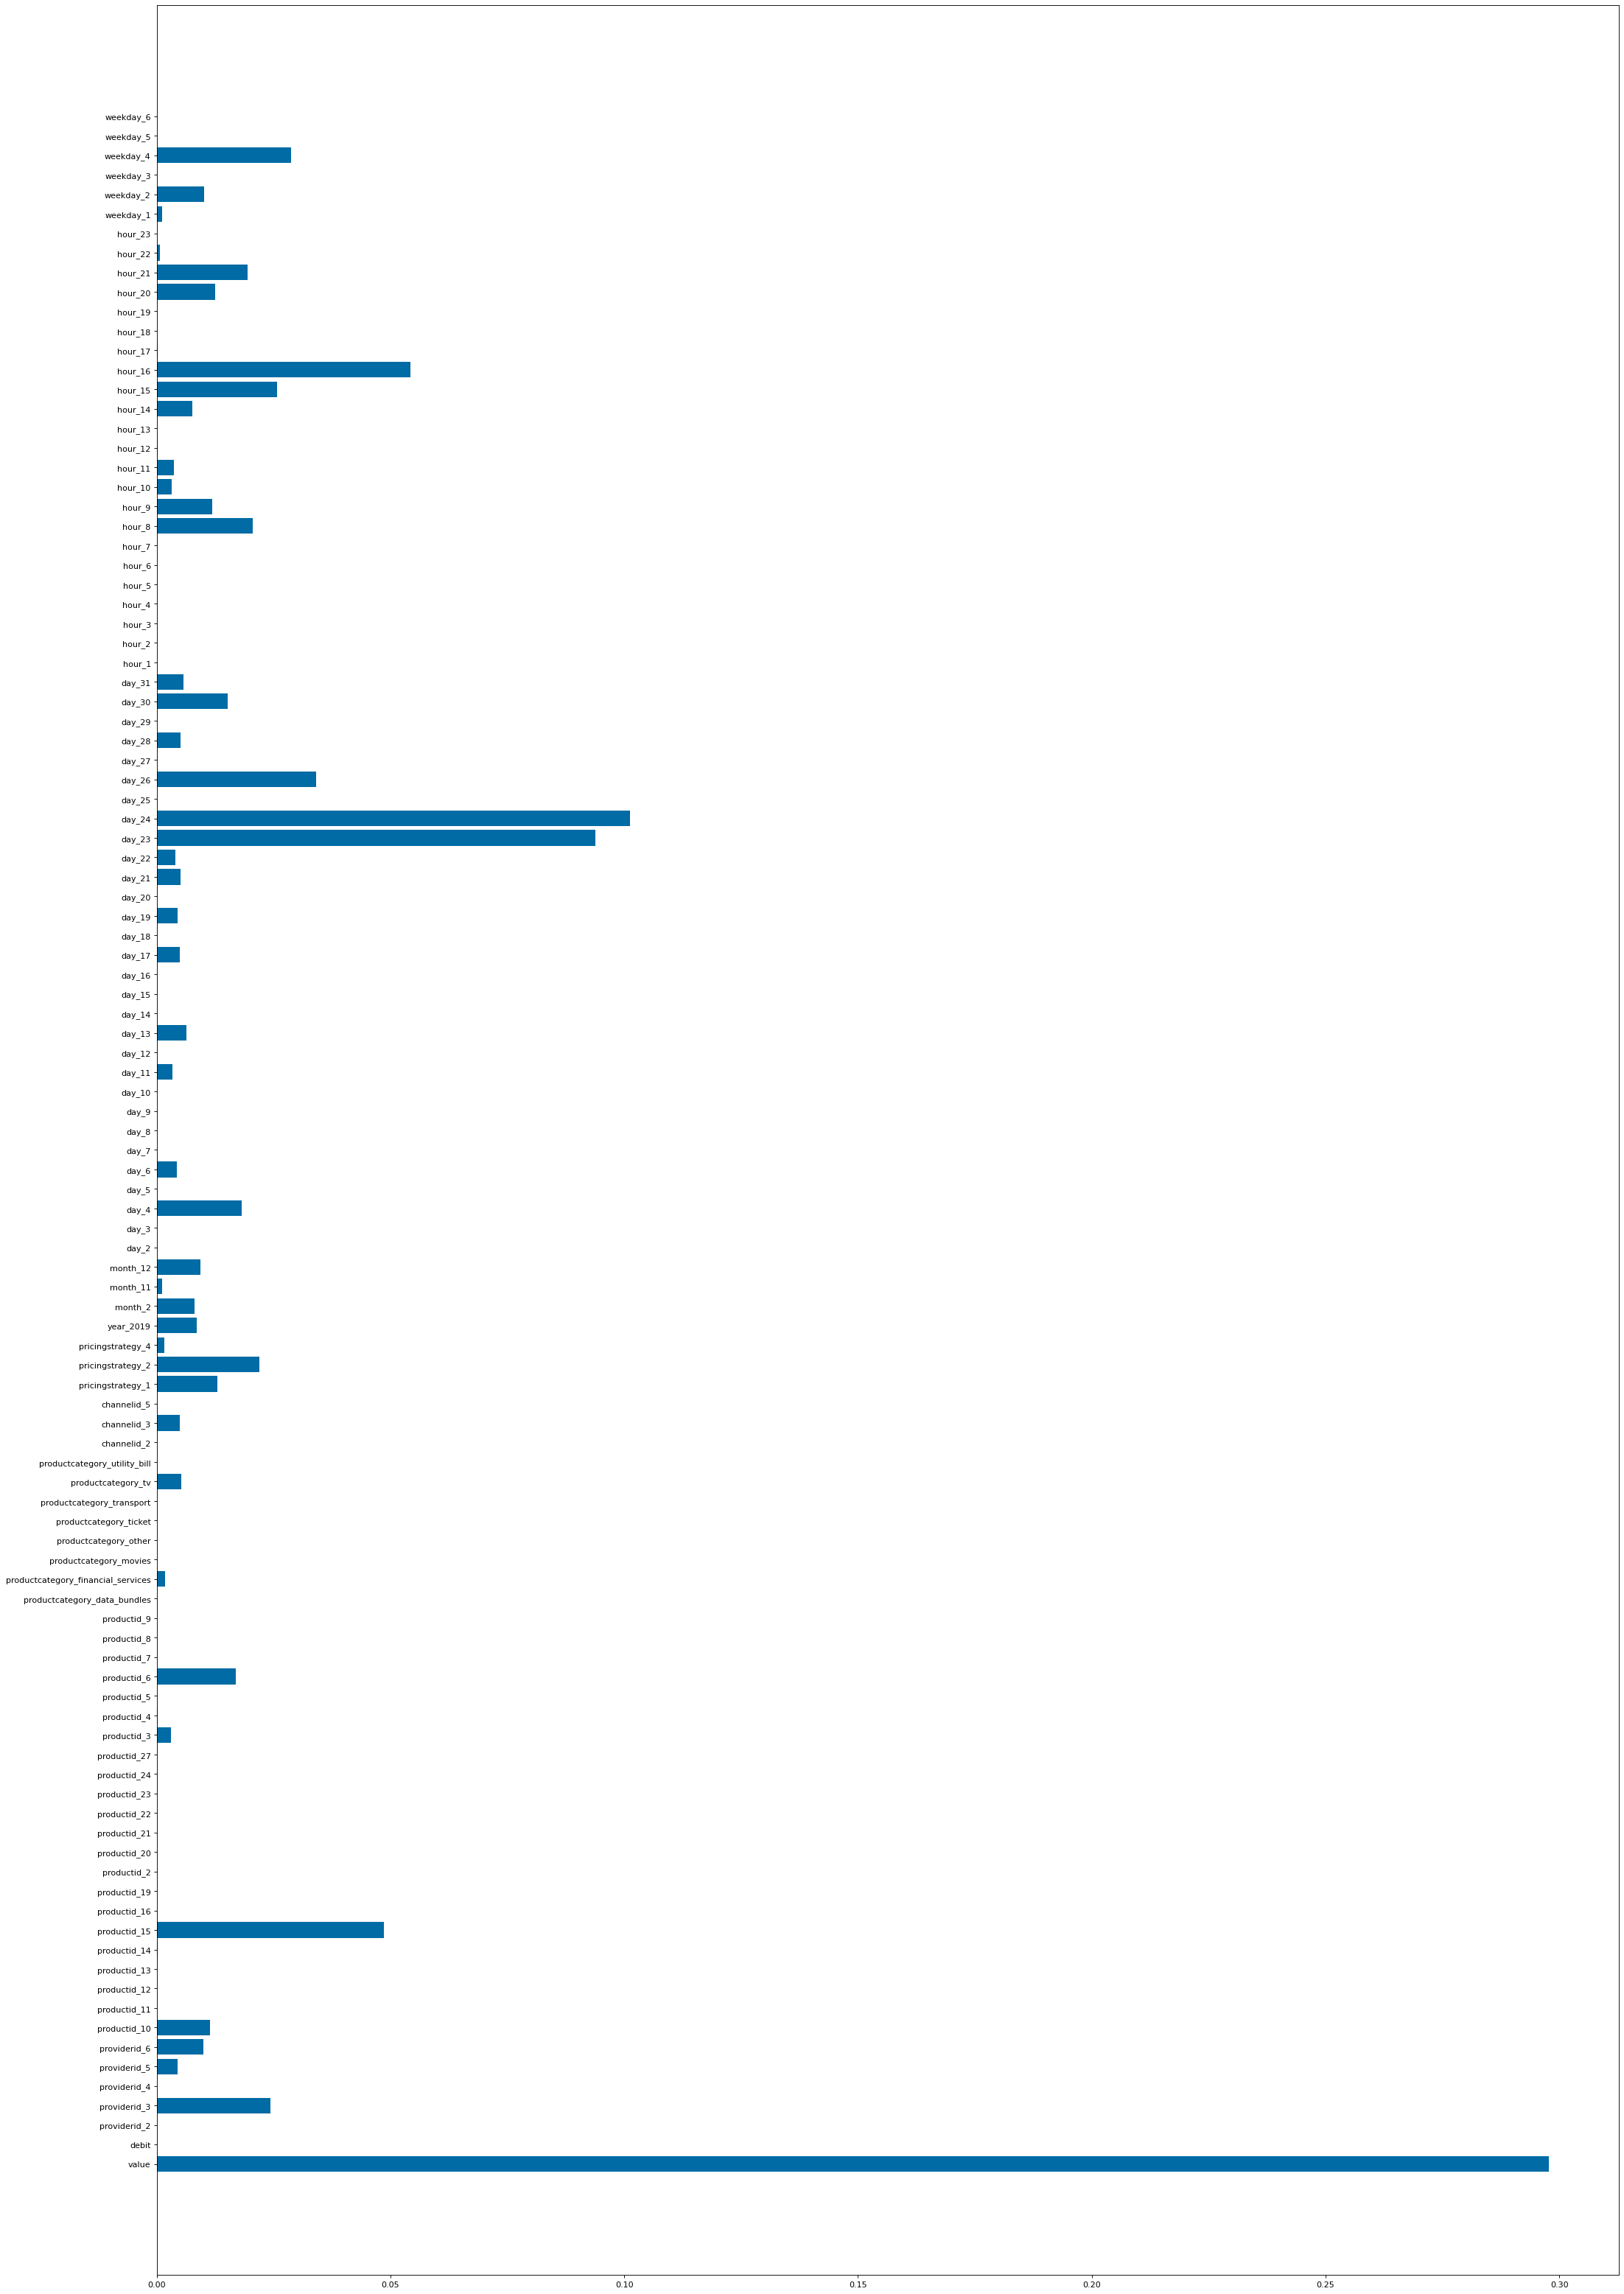

In [30]:
# Trying to show feature importance
"""
    feat_importance = best_clf.feature_importances_
    feature_names = [f"{i}" for i in (X_test_scaled.columns)]
    plt.figure(figsize=(32, 50), dpi=80)
    plt.barh(feature_names, feat_importance)
"""